In [ ]:
%matplotlib inline


UMAP on the MNIST Digits dataset
--------------------------------

A simple example demonstrating how to use UMAP on a larger
dataset such as MNIST. We first pull the MNIST dataset and
then use UMAP to reduce it to only 2-dimensions for
easy visualisation.

Note that UMAP manages to both group the individual digit
classes, but also to retain the overall global structure
among the different digit classes -- keeping 1 far from
0, and grouping triplets of 3,5,8 and 4,7,9 which can
blend into one another in some cases.



**DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pathlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import tensorflow as tf

In [ ]:
import os

PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
print(PROJECT_PATH)
#DATAPATH = os.path.join(PROJECT_PATH,'content/drive/MyDrive','maps_data')
DATAPATH = os.path.join(PROJECT_PATH,'content/drive/MyDrive','MapsDataCities')
print(DATAPATH)

/
/content/drive/MyDrive/MapsDataCities


In [ ]:
import pathlib
data_root = pathlib.Path(DATAPATH)
print(data_root)

/content/drive/MyDrive/MapsDataCities


In [ ]:
import sys
import os
import tensorflow as tf
import random


def preprocess_image(image):
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, [286, 286])
    image /= 255.0  # normalize to [0,1] range

    return image


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


def get_filepaths(dirpath):
    """
    Return paths of all files in a directory.
    :param dirpath:
    :return:
    """
    data_root = pathlib.Path(dirpath)
    all_image_paths = list(data_root.glob('*'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)

    return all_image_paths


def load_dataset(dirpath):

    all_image_paths = get_filepaths(dirpath)
    path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return image_ds

In [ ]:
ds = load_dataset(data_root)

In [ ]:
import numpy as np
import torchvision
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
#import model
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

In [ ]:
# learning parameters
batch_size = 1
epochs = 600
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
kernel_size = 4
stride = 2
padding = 4
dilation= 2
init_kernel = 8 # initial number of filters

In [ ]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=3, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride#, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride#, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride#, padding=padding
        )
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=3, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        
    def encode(self, x):
        #print(x.shape)
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)
        mu = x
        log_var = x

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var
    
    def decode(self, z):
        x = F.relu(self.dec1(z))
        #print(x.shape)
        x = F.relu(self.dec2(x))
        #print(x.shape)
        x = F.relu(self.dec3(x))
        #print(x.shape)
        x = F.relu(self.dec4(x))
        #print(x.shape)
        return torch.sigmoid(self.dec5(x))

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        #print("enc1: " + str(x.size()))
        x = F.relu(self.enc2(x))
        #print("enc2: " + str(x.size()))
        x = F.relu(self.enc3(x))
        #print("enc3: " + str(x.size()))
        x = F.relu(self.enc4(x))
        #print("enc4: " + str(x.size()))
        x = self.enc5(x)
        #print("enc5: " + str(x.size()))
        # get `mu` and `log_var`
        mu = x
        log_var = x
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        #print(z.shape)
 
        # decoding
        x = F.relu(self.dec1(z))
        #print("dec1: " + str(x.size()))
        #print("In channels: " + str(init_kernel))
        #print("Out channels: " + str(init_kernel*8))
        #print("Kernel Size:  constant at 10")
        x = F.relu(self.dec2(x))
        #print("dec2: " + str(x.size()))
        #print("In channels: " + str(init_kernel*8))
        #print("Out channels: " + str(init_kernel*4))
        #print("Kernel Size:  constant at 10")
        x = F.relu(self.dec3(x))
        #print("dec3: " + str(x.size()))
        #print("In channels: " + str(init_kernel*4))
        #print("Out channels: " + str(init_kernel*2))
        #print("Kernel Size:  constant at 10")
        x = F.relu(self.dec4(x))
        #print("dec4: " + str(x.size()))
        #print("In channels: " + str(init_kernel*2))
        #print("Out channels: " + str(init_kernel))
        #print("Kernel Size:  constant at 10")
        reconstruction = torch.sigmoid(self.dec5(x))
        #print("reconstruction: " + str(reconstruction.size()))
        #print("In channels: " + str(init_kernel))
        #print("Out channels: " + str(3))
        #print("Kernel Size:  constant at 10")
        return reconstruction, mu, log_var, z

In [ ]:
from torch.utils import data
import sys

#sys.path.append('../')
from torchvision import datasets
# from skimage import io, transform
import os
import re

from PIL import Image

import torch
from PIL import Image, ImageOps
import numpy as np

import torchvision
import torchvision.transforms.functional as trF


class Invert(object):
    """Inverts the color channels of an PIL Image
    while leaving intact the alpha channel.
    """

    def invert(self, img):
        r"""Invert the input PIL Image.
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        #if not trF._is_pil_image(img):
        #    raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

        if img.mode == 'RGBA':
            r, g, b, a = img.split()
            inv = Image.merge('RGB', (r, g, b))
            #inv = ImageOps.invert(rgb)
            #r, g, b = inv.split()
            #inv = Image.merge('RGBA', (r, g, b, a))
        elif img.mode == 'LA':
            l, a = img.split()
            l = ImageOps.invert(l)
            inv = Image.merge('LA', (l, a))
        else:
            inv = ImageOps.invert(img)
        return inv

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        return self.invert(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

class CityImageDataset(data.Dataset):
    """
    Urban images dataset.
    """

    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = [f for f in os.listdir(root) if not f.startswith('.')]
        #self.image_names = [''.join(re.findall(r'[^\/]+(?=\.)',f)) for f in os.listdir(root) if not f.startswith('.')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root,self.image_files[idx])
        sample = Image.open(img_name)

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __getname__(self, idx):
        return self.image_files[idx]

In [ ]:
city_dataset = CityImageDataset(root=data_root,transform=torchvision.transforms.Compose([    
    #torchvision.transforms.Grayscale(num_output_channels=3),                                                                                 
    Invert(),
    torchvision.transforms.RandomCrop(286),
    torchvision.transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

In [ ]:
validation_split = .0
shuffle_dataset = True
random_seed= 42
dataset_size = len(city_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(city_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(city_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
MODEL_ENCODE = os.path.join(PROJECT_PATH,'content/drive/MyDrive/TrainedModels','ModelBeta_750e_15k_lr001_Beta250')

In [ ]:
model_loaded = ConvVAE().to(device)
model_loaded.load_state_dict(torch.load(MODEL_ENCODE))

<All keys matched successfully>

In [ ]:
test_device = "cpu"
model_loaded.to(test_device)

ConvVAE(
  (enc1): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (enc2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
  (enc3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (enc4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (enc5): Conv2d(64, 8, kernel_size=(4, 4), stride=(2, 2))
  (dec1): ConvTranspose2d(8, 64, kernel_size=(4, 4), stride=(2, 2))
  (dec2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
  (dec3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
  (dec4): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2))
  (dec5): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(2, 2))
)

In [ ]:
import numpy as np
z_images = np.zeros((15062,392))
image_names = []
image_tensors = []
print(type(z_images))
with torch.no_grad():
    for idx, image in tqdm(enumerate(train_loader), total=int(len(train_indices)/train_loader.batch_size)):
        #print(image.shape)
        #z_image = model_loaded.encode(image)[0]#.numpy()
        z_image = model_loaded.encode(image)[0]
        image_name = train_loader.dataset.__getname__(idx)
        #print(torch.flatten(z_image, start_dim=1).shape)
        #print(z_image)
        z_images[idx] = torch.flatten(z_image, start_dim=1)
        #print(z_images[idx].shape)
        image_names.append(image_name)
        #image_tensors.append(image)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
z_images

array([[-0.03317294, -3.31339312, -0.65279329, ..., -3.80942822,
        -3.78550982, -4.06828594],
       [-2.52042437, -1.8035084 , -1.32229006, ..., -1.72888708,
         1.07444382,  0.03299007],
       [-4.1489892 , -0.37135428, -2.7007823 , ..., -4.96337223,
        -5.29428816, -5.71171474],
       ...,
       [-3.33040023, -1.64913607, -4.62674999, ..., -0.61708796,
        -2.22166967, -2.07238841],
       [-1.24842489, -3.93478894, -1.25412953, ..., -3.85226536,
        -3.92940187, -3.88889551],
       [-3.04046178, -3.93463588, -3.93639398, ..., -7.0658884 ,
        -2.95481014, -0.51741666]])

**VISUALISATION** 

In [ ]:
!pip install umap-learn[plot]

     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 1.2MB 11.6MB/s 
     |████████████████████████████████| 15.8MB 346kB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 112kB 53.1MB/s 
     |████████████████████████████████| 706kB 46.4MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=92dcbb6c1d8e76779b770dc4d8e6546967462452b5ee3cfcc0ac8392a686c033
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=0a9ea2f57a64060f5bee9e00fa96f9b9d77013b938ca922f9db84fd1efa88d8a
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
  Created wheel for datashape: filename=datashape-0.5.2-cp37-none-any.whl size=59430 sha256=6b2757adc54db77c2029468f9e4bdae142c19e43e

In [ ]:
#setup
import sklearn
import scipy
import numba
!pip install umap-learn

In [ ]:
!pip install hdbscan

     |████████████████████████████████| 6.4MB 8.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311725 sha256=2ecfafae23bb70ef413e0c4b4d1089b4de1dba1a53a771e000c0983a09f26e25
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

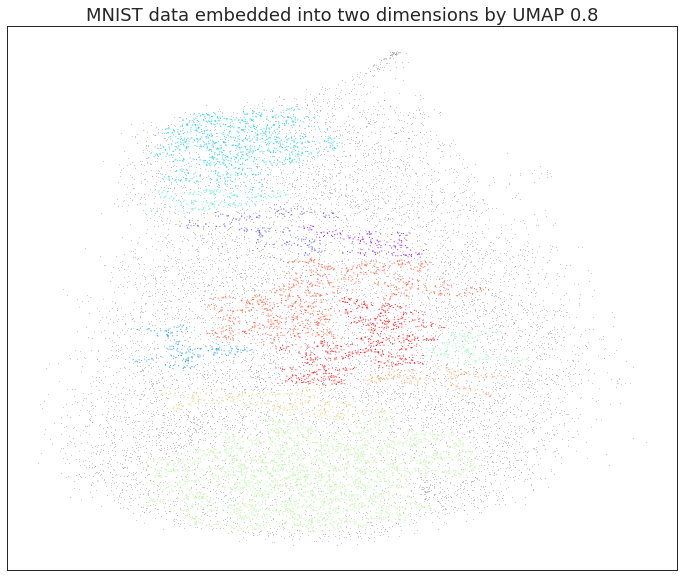

In [ ]:
import umap
import hdbscan
import seaborn as sns

sns.set(context="paper", style="white")

clusterable_embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    random_state= 42,
).fit_transform(z_images)

labels = hdbscan.HDBSCAN(
    min_samples=8,
    min_cluster_size=150,
).fit_predict(clusterable_embedding)

#clustered = (labels >= 0)
clustered = (labels >= 0)

#reducer = umap.UMAP(random_state=42,min_dist=0.1)
#embedding = reducer.fit_transform(z_images)
#standard_embedding = umap.UMAP(random_state=42).fit_transform(z_images)

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(
    clusterable_embedding[clustered, 0], clusterable_embedding[clustered, 1], c=labels[clustered], cmap="rainbow", s=0.1
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by UMAP 0.8", fontsize=18)

plt

In [ ]:
np.unique(labels)

'/content'

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

tsne = TSNE(n_components=4, random_state=0)
embedding = tsne.fit_transform(z_image)

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=labels[clustered], cmap="Spectral", s=0.1
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by TSNE", fontsize=18)

plt

In [ ]:
type(labels)

numpy.ndarray

In [ ]:
#reducer = umap.UMAP(random_state=42,min_dist=0.8)
#embedding = reducer.fit_transform(mnist.data)
import json
with open('min_dist_01_umap_citydataset_clusterable_embedings_beta250VAE_umap08.json', 'w') as outfile:
    json.dump(clusterable_embedding.tolist(), outfile)

In [ ]:
import json
with open('min_dist_01_umap_citydataset_hdbscan_LABELS_beta250VAE_umap08.json', 'w') as outfile:
    json.dump(labels.tolist(), outfile)

In [ ]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(mnist.data)
import json
with open('mnist-embeddings.json', 'w') as outfile:
    json.dump(embedding.tolist(), outfile)

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
embedding = tsne.fit_transform(mnist.data)
import json
with open('tsne-mnist-embeddings.json', 'w') as outfile:
    json.dump(embedding.tolist(), outfile)

In [ ]:
import numpy as np
from mnist import MNIST

In [ ]:
mndata = MNIST('./fashion-mnist/data')
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(z_images)

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=target, cmap="Spectral", s=0.1
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Fashion MNIST data embedded into two dimensions by UMAP", fontsize=18)

plt